# ⏳ (Variational) AutoEncoders

[Deep Learning](https://dsai.units.it/index.php/courses/deep-learning/) Course @ [UniTS](https://portale.units.it/en), Spring 2024

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/deeplearning-units/blob/main/labs/05_autoencoders.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>  <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/emaballarin/deeplearning-units/blob/main/labs/05_autoencoders.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Introduction

AutoEncoders are a class of neural network architectures that are used to learn **efficient representations** of data. They are composed of two main parts: an **encoder** and a **decoder**. The encoder is used to compress the input data into a latent-space representation, while the decoder is used to reconstruct (or generate) the input data from the latent-space representation.

Not a requirement, but in most cases the latent space is much lower-dimensional than the input (and output) space, meaning that the autoencoder is performing **dimensionality reduction**, *i.e.* learning a low-dimensional code that represents the most substantial fraction of the variability of the input data.

If trained with MSE Loss and without nonlinearities, an *autoencoder* it can be shown to perform equivalently to Principal Component Analysis (PCA).

**Variational** autoencoders are a special kind of autoencoders that are trained to learn not only a deterministic mapping from input to latent space and viceversa, but a **probabilistic** mapping. This means that the latent space is not a single point, but a distribution of points. This allows to use the decoder as a stochastic generator, capable of generating new data points that are distributionally similar to the ones seen during training.

<u>**Remark:**</u> *Vanilla* autoencoders are usually used for **data compression** and **denoising**, while *variational* autoencoders are used for **generative tasks**. This is not a strict rule, but a general guideline, though.


The basic structure of an autoencoder is shown in the following figure.

![](https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

Autoencoders are also a specific subset of the much wider class of *encoder/decoder* nertworks.

## Autoencoders for image data

In general, there are no particular constraints on the specific structure of the encoder and decoder of an autoencoder (variational or otherwise). Such choice usually depends on the type of data that is being processed (*e.g.* in choosing between a *CNN-based* or *FCN-based* AE), on the task at hand (loss function, regularisation, variational or not), and on other additional learning requirements (*e.g.* the choice of *straight* vs *U-net-like* AEs).

In the case of image data, the encoder is usually composed of a series of convolutional layers, while the decoder is composed of a series of transposed convolutional layers. The latent space is usually a 1D tensor - usually obtained by *fully-connected* pre/post-processing - but it can be directly a 2D tensor as well.

### Preliminary infrastucture setup

Nothing new here, just the usual cloud-aware setup...

In [1]:
import os

FOLDERNAME: str = "deeplearning_units_2024"
try:
    if os.getenv("COLAB_RELEASE_TAG"):
        # noinspection PyUnresolvedReferences
        from google.colab import drive

        drive.mount(BASEPATH := "/content/drive")
        os.makedirs(FULLPATH := BASEPATH + "/MyDrive/" + FOLDERNAME, exist_ok=True)
    elif os.getenv("KAGGLE_CONTAINER_NAME"):
        os.makedirs(FULLPATH := "/kaggle/working/" + FOLDERNAME, exist_ok=True)
    else:
        os.makedirs(FULLPATH := "./" + FOLDERNAME, exist_ok=True)
    os.chdir(FULLPATH)
except (ModuleNotFoundError, FileExistsError, FileNotFoundError):
    pass

### The imports for the day

In [2]:
import torch as th
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import torchvision as tv

from typing import Union, Callable, Tuple
from tqdm import trange
from typing import List

from math import prod as mult

## Building a (V)AE

The *typical model training* pipeline will be exactly the same as in the previous labs (*e.g.* that on gradient-based training of a FCN on the MNIST dataset), with the only differences being the **dataset** and **model architecture**.

In [3]:
# Hyperparameters
DEVICE_AUTODETECT: bool = True
TRAIN_BATCH_SIZE: int = 64
TEST_BATCH_SIZE: int = 128
EPOCHS: int = 20
CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="mean")
)
LR: float = 2e-3

LATENT_DIM: int = 30

In [4]:
# Device setup
device: th.device = th.device(
    "cuda" if th.cuda.is_available() and DEVICE_AUTODETECT else "cpu"
)

#### The data: CIFAR-10, as usual

In [5]:
cifar_mean: Tensor = th.tensor([[[0.4914]], [[0.4822]], [[0.4465]]]).to(device)
cifar_stdd: Tensor = th.tensor([[[0.2471]], [[0.2435]], [[0.2616]]]).to(device)

cifarten_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

os.makedirs("./data/", exist_ok=True)

train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=cifarten_transforms, download=True
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, transform=cifarten_transforms, download=True
)

train_loader: DataLoader = DataLoader(
    dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True
)
test_loader: DataLoader = DataLoader(
    dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False
)

100%|██████████| 170498071/170498071 [00:08<00:00, 19731602.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Some useful functions and classes to build our model...

In [6]:
# To show data in a grid-like form
def imshow(img) -> None:
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, axes=(1, 2, 0)))

In [7]:
# Reconstruction loss (for [0,1]-scaled inputs)
@th.jit.script
def pixelwise_bce_sum(lhs: Tensor, rhs: Tensor) -> Tensor:
    return F.binary_cross_entropy(lhs, rhs, reduction="sum")

In [8]:
# Beta-VAE loss
@th.jit.script
def beta_gaussian_kldiv(mu: Tensor, sigma: Tensor, beta: float = 1.0) -> Tensor:
    kldiv = 0.5 * (th.pow(mu, 2) + th.exp(sigma) - sigma - 1).sum()
    return beta * kldiv

In [9]:
# Duplex Linear Neck
class DuplexLinearNeck(nn.Module):
    def __init__(self, in_dim: int, latent_dim: int):
        super().__init__()
        self.x_to_mu: nn.Linear = nn.Linear(in_dim, latent_dim)
        self.x_to_log_var: nn.Linear = nn.Linear(in_dim, latent_dim)

    def forward(
        self, xc: Union[Tuple[th.Tensor, ...], List[th.Tensor]]
    ) -> Tuple[th.Tensor, th.Tensor]:
        cxc: th.Tensor = th.cat(xc, dim=1)
        return self.x_to_mu(cxc), self.x_to_log_var(cxc)

In [10]:
# Explicit reparemeterized sampler (the alternative being `torch.rsample`)
class GaussianReparameterizerSampler(nn.Module):
    def __init__(self):
        super().__init__()

    # noinspection PyMethodMayBeStatic
    def forward(self, z_mu: th.Tensor, z_log_var: th.Tensor) -> th.Tensor:
        return z_mu + th.randn_like(z_mu, device=z_mu.device) * th.exp(z_log_var * 0.5)

In [11]:
def field_transform(
    x_input: Tensor,
    pre_sum: Union[float, Tensor] = 0.0,
    mult_div: Union[float, Tensor] = 1.0,
    post_sum: Union[float, Tensor] = 0.0,
    div_not_mul: bool = False,
) -> Tensor:
    if div_not_mul:
        return th.add(
            input=th.div(input=th.add(input=x_input, other=pre_sum), other=mult_div),
            other=post_sum,
        )
    else:
        return th.add(
            input=th.mul(input=th.add(input=x_input, other=pre_sum), other=mult_div),
            other=post_sum,
        )


class FieldTransform(nn.Module):
    def __init__(
        self,
        pre_sum: Union[float, Tensor] = 0.0,
        mult_div: Union[float, Tensor] = 1.0,
        post_sum: Union[float, Tensor] = 0.0,
        div_not_mul: bool = False,
    ):
        super().__init__()
        self.pre_sum: Union[float, Tensor] = pre_sum
        self.mult_div: Union[float, Tensor] = mult_div
        self.post_sum: Union[float, Tensor] = post_sum
        self.div_not_mul: bool = div_not_mul

    def forward(self, x_input: Tensor) -> Tensor:
        return field_transform(
            x_input=x_input,
            pre_sum=self.pre_sum,
            mult_div=self.mult_div,
            post_sum=self.post_sum,
            div_not_mul=self.div_not_mul,
        )

In [12]:
def _make_conv_block(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[int, Tuple[int, int]] = 0,
    leaky_slope: float = 0.2,
) -> nn.Sequential:
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels, affine=True),
        nn.LeakyReLU(leaky_slope),
    )

In [13]:
def _make_decoder_adapter(
    lat_size: int,
    target_shape: Tuple[int, int, int],
    leaky_slope: float = 0.2,
) -> nn.Sequential:
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(lat_size, mult(target_shape)),
        nn.LeakyReLU(leaky_slope),
        nn.Unflatten(1, target_shape),
    )

In [14]:
def _make_deconv_block(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[int, Tuple[int, int]] = 0,
    output_padding: Union[int, Tuple[int, int]] = 0,
    leaky_slope: float = 0.2,
) -> nn.Sequential:
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            output_padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels, affine=True),
        nn.LeakyReLU(leaky_slope),
    )

#### The actual architecture

The encoder will be a relatively simple CNN...

In [15]:
def cifar_encoder(latent: int):
    return th.nn.Sequential(
        FieldTransform(-cifar_mean, cifar_stdd, div_not_mul=True),
        _make_conv_block(3, 32, 3, 2, 1),
        _make_conv_block(32, 64, 3, 2, 1),
        _make_conv_block(64, 128, 3, 2, 1),
        _make_conv_block(128, 256, 3, 2, 1),
        nn.Flatten(),
        nn.Linear(1024, latent),
    )

...while the decoder will be a simple *transposed* CNN.

In [16]:
def cifar_decoder(latent: int):
    return nn.Sequential(
        _make_decoder_adapter(latent, (256, 3, 3)),
        _make_deconv_block(256, 256, 3, 2, 1, 0),
        _make_deconv_block(256, 128, 3, 2, 1, 0),
        _make_deconv_block(128, 64, 3, 2, 1, 0),
        _make_deconv_block(64, 32, 3, 2, 1, 0),
        nn.ConvTranspose2d(32, 3, 2, 1, 1, 0, bias=True),
        nn.Sigmoid(),
    )

Now, let's put everything together!

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, latent: int):
        super().__init__()
        self.encoder = cifar_encoder(latent)
        self.decoder = cifar_decoder(latent)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        latent = self.encoder(x)
        return self.decoder(latent), latent

As far as the VAE is concerned...

In [18]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent: int):
        super().__init__()
        # Same as before
        self.encoder = cifar_encoder(latent)
        self.decoder = cifar_decoder(latent)

        # Distributional parameters from encoded data
        self.neck = DuplexLinearNeck(latent, latent)

        # Sampler
        self.sampler = GaussianReparameterizerSampler()

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        mu, log_var = self.neck([self.encoder(x)])
        latent = self.sampler(mu, log_var)
        return self.decoder(latent), mu, log_var

And now, we just need to train!

#### Training

In [19]:
# model: Union[AutoEncoder, VariationalAutoEncoder] = AutoEncoder(LATENT_DIM).to(device)
model: Union[AutoEncoder, VariationalAutoEncoder] = VariationalAutoEncoder(
    LATENT_DIM
).to(device)
model.train()

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): FieldTransform()
    (1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

In [20]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=LR, weight_decay=0
)

In [21]:
eval_losses: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()

    for batch_idx, batched_datapoint in enumerate(train_loader):

        x, _ = batched_datapoint
        x = x.to(device)

        # Forward pass + loss computation
        if isinstance(model, VariationalAutoEncoder):
            xhat, mu, log_var = model(x)
            loss = pixelwise_bce_sum(xhat, x) + beta_gaussian_kldiv(mu, log_var)
        else:
            xhat, _ = model(x)
            loss = pixelwise_bce_sum(xhat, x)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    model.eval()

    eval_loss: Tensor = th.zeros(1, device=device)
    with th.no_grad():
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, _ = batched_datapoint_e
            x_e = x_e.to(device)
            if isinstance(model, VariationalAutoEncoder):
                xhat_e, mu_e, log_var_e = model(x_e)
                eval_loss += pixelwise_bce_sum(xhat_e, x_e) + beta_gaussian_kldiv(
                    mu_e, log_var_e
                )
            else:
                xhat_e, _ = model(x_e)
                eval_loss += pixelwise_bce_sum(xhat_e, x_e)

        eval_losses.append(eval_loss.item())

Training epoch: 100%|██████████| 20/20 [24:55<00:00, 74.80s/it] 


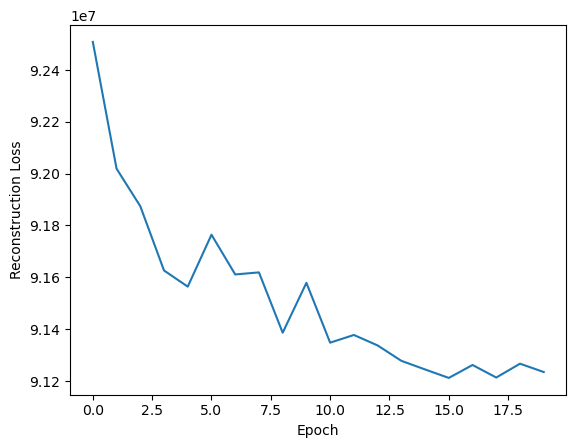

In [22]:
plt.plot(eval_losses)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.show()

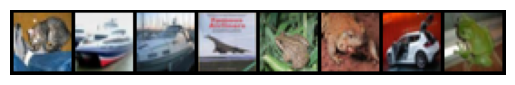

In [23]:
test_imgs = list(test_loader)[0][0][:8]
imshow(tv.utils.make_grid(test_imgs, normalize=True))

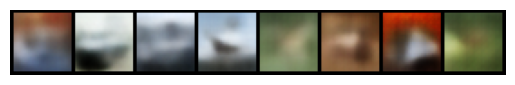

In [24]:
reconstructed_imgs = model(test_imgs.to(device))[0].detach().cpu()
imshow(tv.utils.make_grid(reconstructed_imgs, normalize=True))

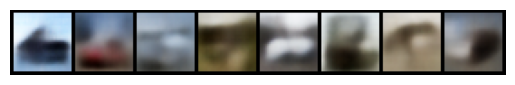

In [25]:
imshow(
    tv.utils.make_grid(
        model.decoder(th.randn(8, LATENT_DIM).to(device)).cpu(), normalize=True
    )
)